Implementation of CycleGAN to perform unpaired image-to-image translation between X-ray and RGB images

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_xray="/content/drive/MyDrive/XRAY_IMAGES"

In [ ]:
dataset_rgb="/content/drive/MyDrive/RGB_IMAGES"

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model

In [ ]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from matplotlib import pyplot

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5okqpuj1
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5okqpuj1
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=650f538ae0ec3a2be62effebf4f92f098a0a6762481262a97d192daf2a351896
  Stored in directory: /tmp/pip-ephem-wheel-cache-dkhs7vk6/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
from datetime import datetime
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

In [ ]:
# definition of the discriminator model

def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	# Convolution layers definitions
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# output from the convolution layers
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])

	return model


In [ ]:
# definition of res_net block

def resnet_block(n_filters, input_layer):

	init = RandomNormal(stddev=0.02)

	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)

	g = Concatenate()([g, input_layer])

	return g

In [ ]:
# definition of the generator model

def define_generator(image_shape, n_resnet=9):

	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	for _ in range(n_resnet):
		g = resnet_block(256, g)

	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)

	return model


In [ ]:
# definition of composite model to update generator

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# using composite model one generator at a time
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)

	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)

	# cycle loss - forward
	output_f = g_model_2(gen1_out)

	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

	opt = Adam(lr=0.0002, beta_1=0.5)

	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)

	return model


In [ ]:
# loading the training images

def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5

	return [X1, X2]


In [ ]:
# selecting random samples to generate images and target image

def generate_real_samples(dataset, n_samples, patch_shape):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))

	return X, y

In [ ]:
# generating images and target

def generate_fake_samples(g_model, dataset, patch_shape):
	X = g_model.predict(dataset)
	y = zeros((len(X), patch_shape, patch_shape, 1))

	return X, y

In [ ]:
# saving the generator models

def save_models(step, g_model_AtoB, g_model_BtoA):
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# periodically generating images to plot input and output images

def summarize_performance(step, g_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	X_out, _ = generate_fake_samples(g_model, X_in, 0)

	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])

	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])

	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()


In [ ]:
# updating image pool for fake images andupdating discriminators using previously generated images

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			selected.append(image)
		else:
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image

	return asarray(selected)

In [ ]:
# training the CycleGAN models.
# here, model_A is being used to define X-ray images while model_b for RGB images

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	n_patch = d_model_A.output_shape[1]

	trainA, trainB = dataset

	poolA, poolB = list(), list()

	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):

		# selecting actual samples from both image sets
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

		# generating fake samples using the generators
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

		# updating fake images being generated
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# updating generator for RGB to X-ray
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

		# updating discriminator for X-ray images generated
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

    # updating generator for X-ray to RGB
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

		# updating discriminator for RGB images generated
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

		# summarizing performance
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot X-ray to RGB
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot RGB to X-ray
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			save_models(i, g_model_AtoB, g_model_BtoA)


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt

In [ ]:
# loading image dataset

def load_images(path, size=(256,256)):
	data_list = list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)

	return asarray(data_list)

In [ ]:
# load dataset for X-ray images

dataA_all=load_images('/content/drive/MyDrive/XRAY_IMAGES/')

from sklearn.utils import resample
# subset of the images
dataA = resample(dataA_all, replace=True, n_samples=50, random_state=42)


In [ ]:
# load dataset for RGB images

dataB_all=load_images('/content/drive/MyDrive/RGB_IMAGES/')

# subset of the images
print('Loaded dataB: ', dataB_all.shape)
dataB = resample(dataB_all, replace=True, n_samples=50, random_state=42)

Loaded dataB:  (150, 256, 256, 3)


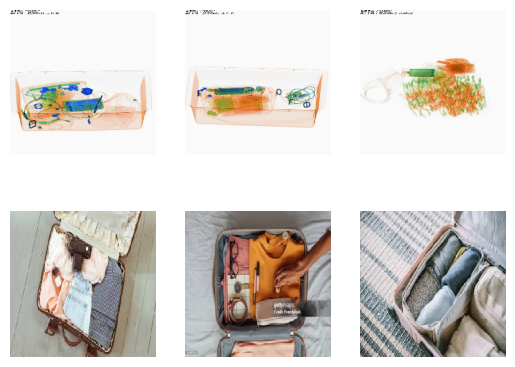

In [ ]:
# ploting X-ray images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))

# ploting RGB images
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))

plt.show()


In [ ]:
# loading datasets

data = [dataA, dataB]
print('Loaded', data[0].shape, data[1].shape)

Loaded (50, 256, 256, 3) (50, 256, 256, 3)


In [ ]:
# preprocessing data

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
# defining all the above models to use

image_shape = dataset[0].shape[1:]

# generator: X-ray to RGB
g_model_AtoB = define_generator(image_shape)
# generator: RGB to X-ray
g_model_BtoA = define_generator(image_shape)

# discriminator: X-ray
d_model_A = define_discriminator(image_shape)
# discriminator: RGB
d_model_B = define_discriminator(image_shape)

# composite model for X-ray
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite model for RGB
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
from datetime import datetime
start1 = datetime.now()
# training models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=10)

stop1 = datetime.now()
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 1s/step
Iteration>1, dA[1.698,3.838] dB[1.462,9.117] g[21.282,24.345]
1/1 [==============================] - 0s 20ms/step
Iteration>2, dA[27.604,22.812] dB[58.264,24.388] g[199.346,48.610]
1/1 [==============================] - 0s 22ms/step
Iteration>3, dA[22.733,11.391] dB[22.663,5.856] g[45.885,76.185]
1/1 [==============================] - 0s 30ms/step
Iteration>4, dA[2.455,3.765] dB[3.329,1.210] g[25.014,22.240]
1/1 [==============================] - 0s 21ms/step
Iteration>5, dA[1.221,0.535] dB[1.505,1.638] g[19.048,19.967]
1/1 [==============================] - 0s 22ms/step
Iteration>6, dA[0.639,0.368] dB[0.658,1.799] g[18.356,18.790]
1/1 [==============================] - 0s 20ms/step
Iteration>7, dA[0.289,0.342] dB[0.297,0.846] g[14.802,15.965]
1/1 [==============================] - 0s 40ms/step
Iteration>8, dA[0.221,0.377] dB[0.897,0.181] g[16.588,16.965]
1/1 [==============================] - 0s 69ms/step
Iteration>9, dA[0.257,0.217] d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: g_model_AtoB_000250.h5 and g_model_BtoA_000250.h5
1/1 [==============================] - 0s 22ms/step
Iteration>251, dA[0.037,0.062] dB[0.075,0.107] g[9.271,10.859]
1/1 [==============================] - 0s 32ms/step
Iteration>252, dA[0.076,0.069] dB[0.138,0.359] g[9.996,10.642]
1/1 [==============================] - 0s 24ms/step
Iteration>253, dA[0.023,0.010] dB[0.129,0.083] g[9.752,11.572]
1/1 [==============================] - 0s 26ms/step
Iteration>254, dA[0.012,0.015] dB[0.343,0.198] g[12.003,12.408]
1/1 [==============================] - 0s 23ms/step
Iteration>255, dA[0.012,0.006] dB[0.080,0.050] g[10.898,12.637]
1/1 [==============================] - 0s 21ms/step
Iteration>256, dA[0.026,0.077] dB[0.258,0.113] g[9.658,10.992]
1/1 [==============================] - 0s 34ms/step
Iteration>257, dA[0.072,0.029] dB[0.083,0.054] g[12.822,12.570]
1/1 [==============================] - 0s 21ms/step
Iteration>258, dA[0.061,0.103] dB[0.336,0.242] g[12.036,12.097]
1/1 [=============

>Saved: g_model_AtoB_000500.h5 and g_model_BtoA_000500.h5
Execution time is:  0:21:34.457661


In [ ]:
# selecting random sample of images

def select_sample(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]

	return X

In [ ]:
# plotting the actual image, generated image, and reconstructed image

def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0

	for i in range(len(images)):
		pyplot.subplot(1, len(images), 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])

	pyplot.show()

In [ ]:
A_data = resample(dataA_all, replace=True, n_samples=50, random_state=42)

B_data = resample(dataB_all, replace=True, n_samples=50, random_state=42)

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


In [ ]:
# load the models

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/g_model_AtoB_000500.h5', cust)
model_BtoA = load_model('/content/g_model_BtoA_000500.h5', cust)


1/1 [==============================] - 0s 22ms/step


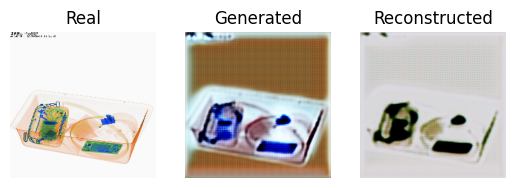

In [ ]:
# X-ray to RGB to X-ray

A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

1/1 [==============================] - 0s 22ms/step


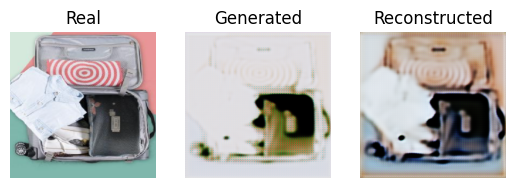

In [ ]:
# RGB to X-ray to RGB

B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

1/1 [==============================] - 0s 22ms/step


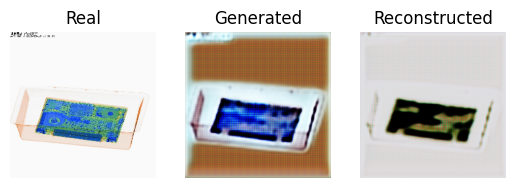

In [ ]:
# X-ray to RGB to X-ray

A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

1/1 [==============================] - 0s 23ms/step


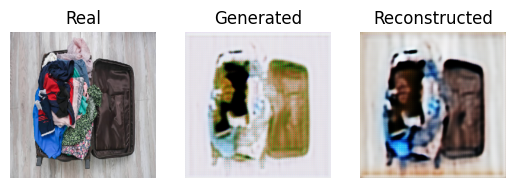

In [ ]:
# RGB to X-ray to RGB

B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)